In [1]:
import scipy
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
from fooof import FOOOF
import pycatch22

# General Pipeline Guidelines
- Analysis: https://neurodsp-tools.github.io/neurodsp/
- Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py
- time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py
- Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
- Catch 22: https://github.com/DynamicsAndNeuralSystems/catch22
- FOOOF: https://github.com/fooof-tools/fooof , https://github.com/valentinealissa/FOOOFy  

Notes and to-do:
- double check if FOOOF is taking log or no-log power spectrum
- check if FOOOF can allow for peak search constrain, force select 2 peaks? more/less senstive for peak fitting
- do visual examination before analysis piple, aka plot your raw data 
- run all data for pre-post (see PPT example)

# Data Loading

- 8140926_F2Ps_F6Ps
- 8151020_F2Ps_F5Ps
- 7010320_F3Ps_F6Ps

In [6]:
# Loading data from data folder
# local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
local_directory = 'D:\Data_20230320'
mat_files = glob.glob(f'{local_directory}/*.mat')
mat_files

['D:\\Data_20230320\\LT1D-2.006F0002.mat',
 'D:\\Data_20230320\\LT1D-2.006F0003.mat',
 'D:\\Data_20230320\\LT1D-2.006F0006.mat',
 'D:\\Data_20230320\\LT1D-2.006F0009.mat',
 'D:\\Data_20230320\\LT1D-2.006F0010.mat',
 'D:\\Data_20230320\\LT1D-2.006F0001.mat']

In [7]:
or_lfp = ['D:\\Data_20230320\\LT1D-2.006F0003.mat', 'D:\\Data_20230320\\LT1D-2.006F0006.mat']

In [8]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

data_all = load_mat(or_lfp)

always look at the original sampling rate first before going to downsample.

In [9]:
def load_channel(data, channel_name, downsample_factor=False):
    '''
    This function load a specific channel from one raw data file. Downsampling of the data should be applied once sampling rate has been examined.
    Input--------------------------
    data: 1xn, data signal
    channel_name: string, recording channel name
    downsample_factor: int
    Output-------------------------
    channel: raw or downsampled data
    sample_hz: sampling rate in Hz
    duration: total recording duration
    t_begin: relative recording start time
    t_end: relative recording end time
    '''

    channel = data[channel_name].flatten()
    sampling_rate = channel_name + '_KHz'
    channel_hz = data[sampling_rate].flatten()*1000

    #downsample data
    channel = signal.decimate(channel, downsample_factor)
    sample_hz = channel_hz/downsample_factor
    if np.mod(channel_hz, downsample_factor) != 0:
        raise ValueError('Check your downsample factor')
  
    #get recording duration
    duration = channel.shape[0]/(60.0*channel_hz/downsample_factor) #float operation and dont forget data already downsampled
    print(f"{channel_name} was downsampled from {channel_hz[0]} to {sample_hz[0]} hz for {round(duration[0],2)} minutes")

    #get recording start and end time
    t_begin = channel_name + '_TimeBegin'
    t_begin = data[t_begin]
    t_end = channel_name + '_TimeEnd'
    t_end = data[t_end]
    
    return channel, sample_hz, duration, t_begin, t_end 

In [10]:
#need to set the downsample_factor based on actual sampling rate first
pre_raw, pre_hz, pre_t, pre_begin, pre_end = load_channel(data_all[0], 'CRAW_01', downsample_factor = 44)
post_raw, post_hz, post_t, post_begin, post_end = load_channel(data_all[1], 'CRAW_01', downsample_factor = 44)

CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.6 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.5 minutes


# FOOOF and Catch22

In [31]:
def ff22(data, hz, sess, **kwargs):
    '''
    This function takes in a single signal and outputs a 1x29 dataframe containing the results from catch22 and FOOOF analysis.
    Input--------------------------
    data: 1xn, data signal
    hz: sampling rate
    sess: data file identification
    kwargs-------------------------
    For details see "Defining the model Settings" section on https://fooof-tools.github.io/fooof/
    'freq_range': 1x2 array, [min, max]
    'max_n_peaks': integer, default = 3 for DBS fitting
    'peak_width_limits': 1x2 array, [min, max], default = [1,8]
    'min_peak_height': float, default = 0.1
    Output-------------------------
    df: 1x29 pandas dataframe
    '''
    # Catch22 
    c22 = pycatch22.catch22_all(data)

    # FOOOF optional fitting specification
    FOOOF_kwargs = {}
    if 'freq_range' in kwargs:
        freq_range = kwargs['freq_range']
    else:
        freq_range = [2, 32] # Define frequency range across which to model the spectrum
    if 'max_n_peaks' in kwargs:
        FOOOF_kwargs['max_n_peaks'] = kwargs['max_n_peaks']
    else:
        FOOOF_kwargs['max_n_peaks'] = 3
    if 'peak_width_limits' in kwargs:
        FOOOF_kwargs['peak_width_limits'] = kwargs['peak_width_limits']
    else:
        FOOOF_kwargs['peak_width_limits'] = [1,8]
    if 'min_peak_height' in kwargs:
        FOOOF_kwargs['min_peak_height'] = kwargs['min_peak_height']
    else:
        FOOOF_kwargs['min_peak_height'] = 0.1
    
    freq_mean, psd_mean = compute_spectrum(data, hz, method='welch', avg_type='mean', nperseg=hz*2)
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]

    fm = FOOOF(**FOOOF_kwargs) # Initialize FOOOF object

    fm.fit(new_freq, new_psd, freq_range)
    fm.report(new_freq, new_psd, freq_range)

    # Data organization
    c22_df = pd.DataFrame.from_dict(c22, orient='index')
    c22_df.columns = c22_df.iloc[0]
    c22_df.reset_index(inplace=True)
    c22_df.drop(0, inplace=True)
    c22_df.reset_index(inplace=True)
    c22_df.drop(['level_0', 'index'], axis=1, inplace=True)

    ff_param = fm.peak_params_
    aperiodic = fm.aperiodic_params_.reshape((1, 2))
    params_dic = {'offset': aperiodic[0,0], 'exponent':aperiodic[0,1],'n_peak': ff_param.shape[0], 'CF': [ff_param[:,0]], 'PW': [ff_param[:,1]], 'BW': [ff_param[:,2]]}
    ff_df = pd.DataFrame.from_dict(params_dic)

    df = pd.concat([c22_df, ff_df], axis=1)
    df.insert(loc=0, column='sess', value=sess)

    return df

(-1000.0, 1000.0)

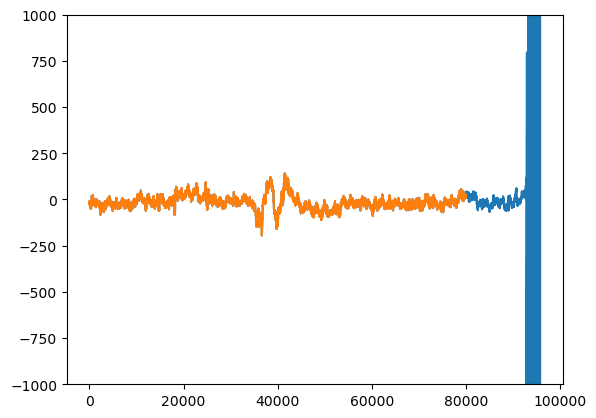

In [13]:
#visualize raw data first
plt.plot(pre_raw)
plt.ylim(-1000,1000)
# 50~80

sub = pre_raw[0:80000]
plt.plot(sub)
plt.ylim(-1000,1000)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

,sess,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,...,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,offset,exponent,n_peak,CF,PW,BW
0,pre_op,-0.277782,0.17973,834.200452,1113,0.760788,-0.000048,0.16179,5310.0,0.00238,...,0.26,0.68,0.001438,0.049194,2.33114,2.192523,2,"[9.831154823529847, 18.103553206540873]","[0.5505739505247779, 0.652871204795592]","[3.513227324087132, 6.7960330351079925]"


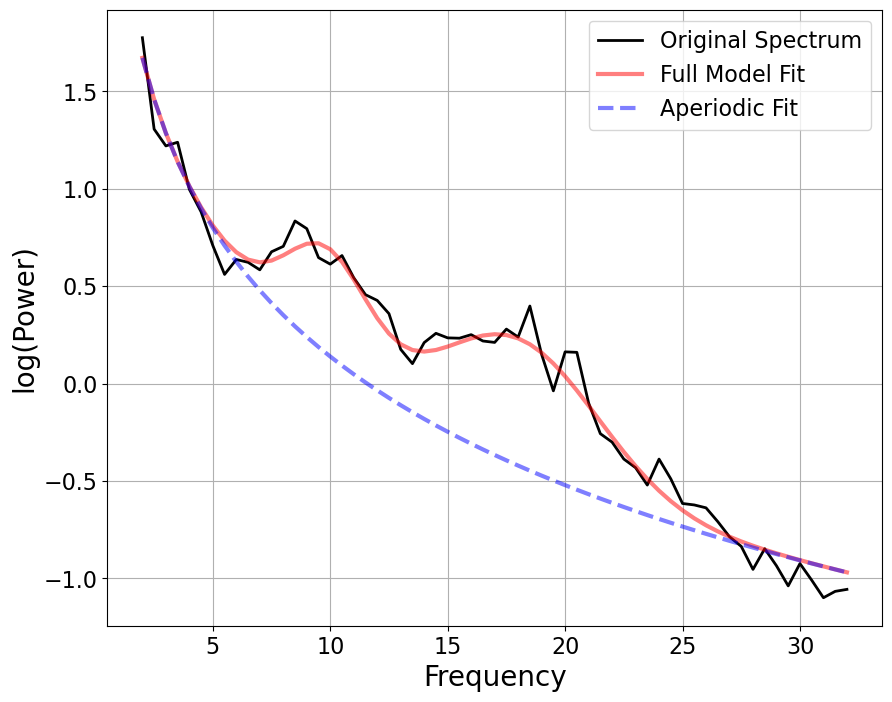

In [24]:
ff22(sub, pre_hz, 'pre_op', **{'max_n_peaks':6})

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 80 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.5251, 2.4602                                          
                                                                                                  
                                       3 peaks were found:                                        
          

,sess,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,...,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,offset,exponent,n_peak,CF,PW,BW
0,post_op,-0.693336,-0.206072,987.371739,1147,0.751559,-0.000058,0.217949,3868.0,0.008903,...,0.76,0.72,0.001103,0.054371,2.525125,2.460229,3,"[9.99769653697182, 18.372239704279206, 59.9800...","[0.5576809809070191, 0.7490570260854299, 1.539...","[3.8458235264293883, 7.999999999999999, 1.0000..."


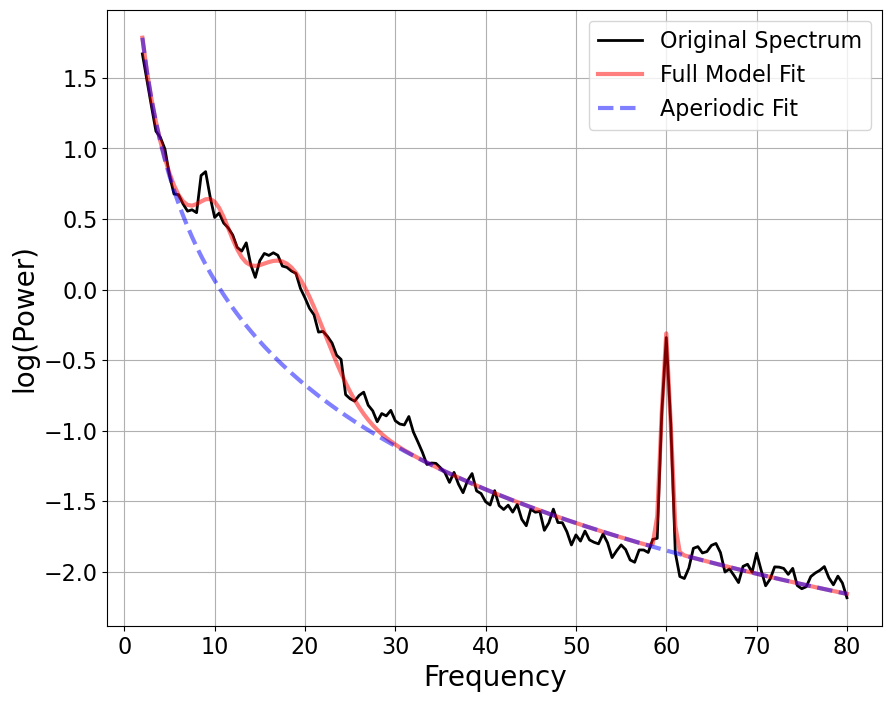

In [32]:
kwargs = {'max_n_peaks':6, 'freq_range': [2,80]}
ff22(post_raw, post_hz, 'post_op', max_n_peaks=6, freq_range=[2,80])

# Power spectral
This code block generate power spectral for each individual recording session for quick visualization of the session quality.


NOTES:
- There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.
- Need to ask all the hardware filter that has been applied to the raw data. 

In [17]:
#plot for each file 
freq_list = []
psd_list = []

for m in or_lfp:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CRAW_01'].flatten()
    CLFP_hz = file['CRAW_01_KHz'].flatten()*1000
    freq_mean, psd_mean = compute_spectrum(CLFP_01, CLFP_hz, method='welch', avg_type='mean', nperseg=CLFP_hz*2)

    #subset the frequence range below 120 hz
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]
    freq_list.append(new_freq)
    psd_list.append(new_psd)


IndexError: list index out of range

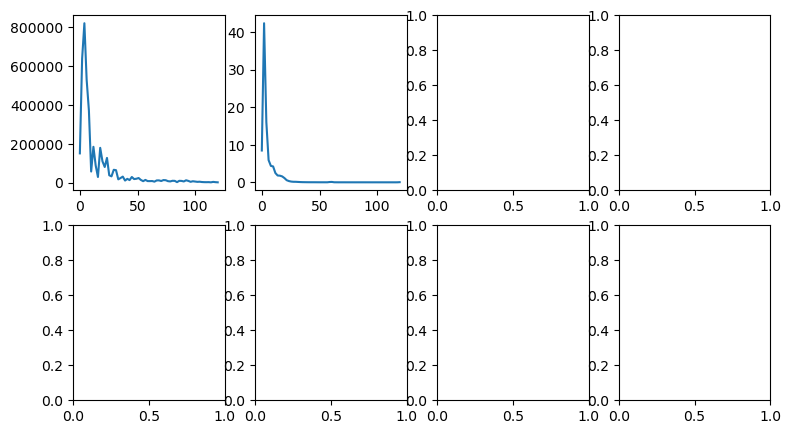

In [18]:
f, ax = plt.subplots(2,4, figsize=(9,5))

ax[0,0].plot(freq_list[0], psd_list[0])
ax[0,1].plot(freq_list[1], psd_list[1])
ax[0,2].plot(freq_list[2], psd_list[2])
ax[0,3].plot(freq_list[3], psd_list[3])

ax[1,0].plot(freq_list[4], psd_list[4])
ax[1,1].plot(freq_list[5], psd_list[5])
ax[1,2].plot(freq_list[6], psd_list[6])
ax[1,3].plot(freq_list[7], psd_list[7])

# Pre-processing IIR filtering

Note:
- bandstop, exclusion.
- bandpass, inclusion. 

In [ ]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal

In [ ]:
#filtering test for CLFP
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

In [ ]:
#filtering test for Raw data
f_range = (58, 62)
sig_filt = filter_signal(pre_raw, 1000, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
# plt.plot(sig_filt[0:10000]) #filtered
plt.plot(pre_raw[0:10000]) #raw
plt.plot(sig_filt[0:10000]) #filtered